In [3]:
!pip install optuna shap

   ---------------------------------------- 0.0/362.8 kB ? eta -:--:--
   --- ------------------------------------ 30.7/362.8 kB 1.3 MB/s eta 0:00:01
   ------------- -------------------------- 122.9/362.8 kB 1.8 MB/s eta 0:00:01
   --------------------------------- ------ 307.2/362.8 kB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 362.8/362.8 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.2 kB ? eta -:--:--
   ---------------------------------------- 233.2/233.2 kB ? eta 0:00:00
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB ? eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import List
from sklearn.model_selection import train_test_split
from catboost import (
    CatBoostClassifier,
    Pool
)
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

shap.initjs()
warnings.filterwarnings("ignore")
%matplotlib inline

TRAIN_FILE = '../data/processed/train_processed.parquet'
TEST_FILE = '../data/processed/test_processed.parquet'
SAMPLE_SUBMISSION = '../data/raw/sample_submission.csv'

In [5]:
def set_display() -> None:
    """Function sets display options for charts and pd.DataFrames."""
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def dataset_info(df: pd.DataFrame):
    print(df.info())
    
    print("\nПропуски в полях:")
    print(df.isnull().sum())

In [6]:
train_df = pd.read_parquet(TRAIN_FILE, engine='auto')
test_df = pd.read_parquet(TEST_FILE, engine='auto')
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)

In [7]:
dataset_info(train_df)

<class 'pandas.core.frame.DataFrame'>
Index: 79912 entries, 0 to 79999
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       79912 non-null  int32  
 1   start_date                               79912 non-null  int16  
 2   end_date                                 79912 non-null  int16  
 3   duration                                 79912 non-null  int16  
 4   linear_trend                             79912 non-null  float16
 5   phase_duration                           79912 non-null  float16
 6   max_trend_length                         79912 non-null  float16
 7   time_series_entropy                      79912 non-null  float16
 8   calculate_iqr                            79912 non-null  float16
 9   variance_larger_than_standard_deviation  79912 non-null  bool   
 10  has_duplicate_max                        79912 non-

In [8]:
dataset_info(test_df)

<class 'pandas.core.frame.DataFrame'>
Index: 19979 entries, 0 to 19999
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       19979 non-null  int32  
 1   start_date                               19979 non-null  int16  
 2   end_date                                 19979 non-null  int16  
 3   duration                                 19979 non-null  int16  
 4   linear_trend                             19979 non-null  float16
 5   phase_duration                           19979 non-null  int8   
 6   max_trend_length                         19979 non-null  int8   
 7   time_series_entropy                      19979 non-null  float16
 8   calculate_iqr                            19979 non-null  float16
 9   variance_larger_than_standard_deviation  19979 non-null  float16
 10  has_duplicate_max                        19979 non-

In [9]:
sample_submission.shape

(20001, 2)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79912 entries, 0 to 79999
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       79912 non-null  int32  
 1   start_date                               79912 non-null  int16  
 2   end_date                                 79912 non-null  int16  
 3   duration                                 79912 non-null  int16  
 4   linear_trend                             79912 non-null  float16
 5   phase_duration                           79912 non-null  float16
 6   max_trend_length                         79912 non-null  float16
 7   time_series_entropy                      79912 non-null  float16
 8   calculate_iqr                            79912 non-null  float16
 9   variance_larger_than_standard_deviation  79912 non-null  bool   
 10  has_duplicate_max                        79912 non-

,id,start_date,end_date,duration,linear_trend,phase_duration,max_trend_length,time_series_entropy,calculate_iqr,variance_larger_than_standard_deviation,...,absolute_maximum,minimum,benford_correlation,autocorrelation_lag_1,fft_coefficient_0,fft_coefficient_1,number_crossing_0,energy_ratio_by_chunks,permutation_entropy,target
75048,10178,17167,19174,2007,-0.007557,7.0,5.0,2.017578,1.309570,True,...,2.939453,-2.849609,0.951172,0.107361,5.898438,10.265625,31,0.006851,0.991699,0.0
16129,43856,17987,19327,1340,-0.025970,8.0,4.0,1.976562,1.570312,True,...,3.289062,-3.289062,0.888672,0.447510,0.409912,7.695312,11,0.223511,0.979980,0.0
65282,70568,17257,18659,1402,-0.032806,6.0,3.0,2.001953,1.700195,True,...,3.800781,-2.050781,0.807129,0.123962,5.523438,19.390625,20,0.031250,0.974609,1.0


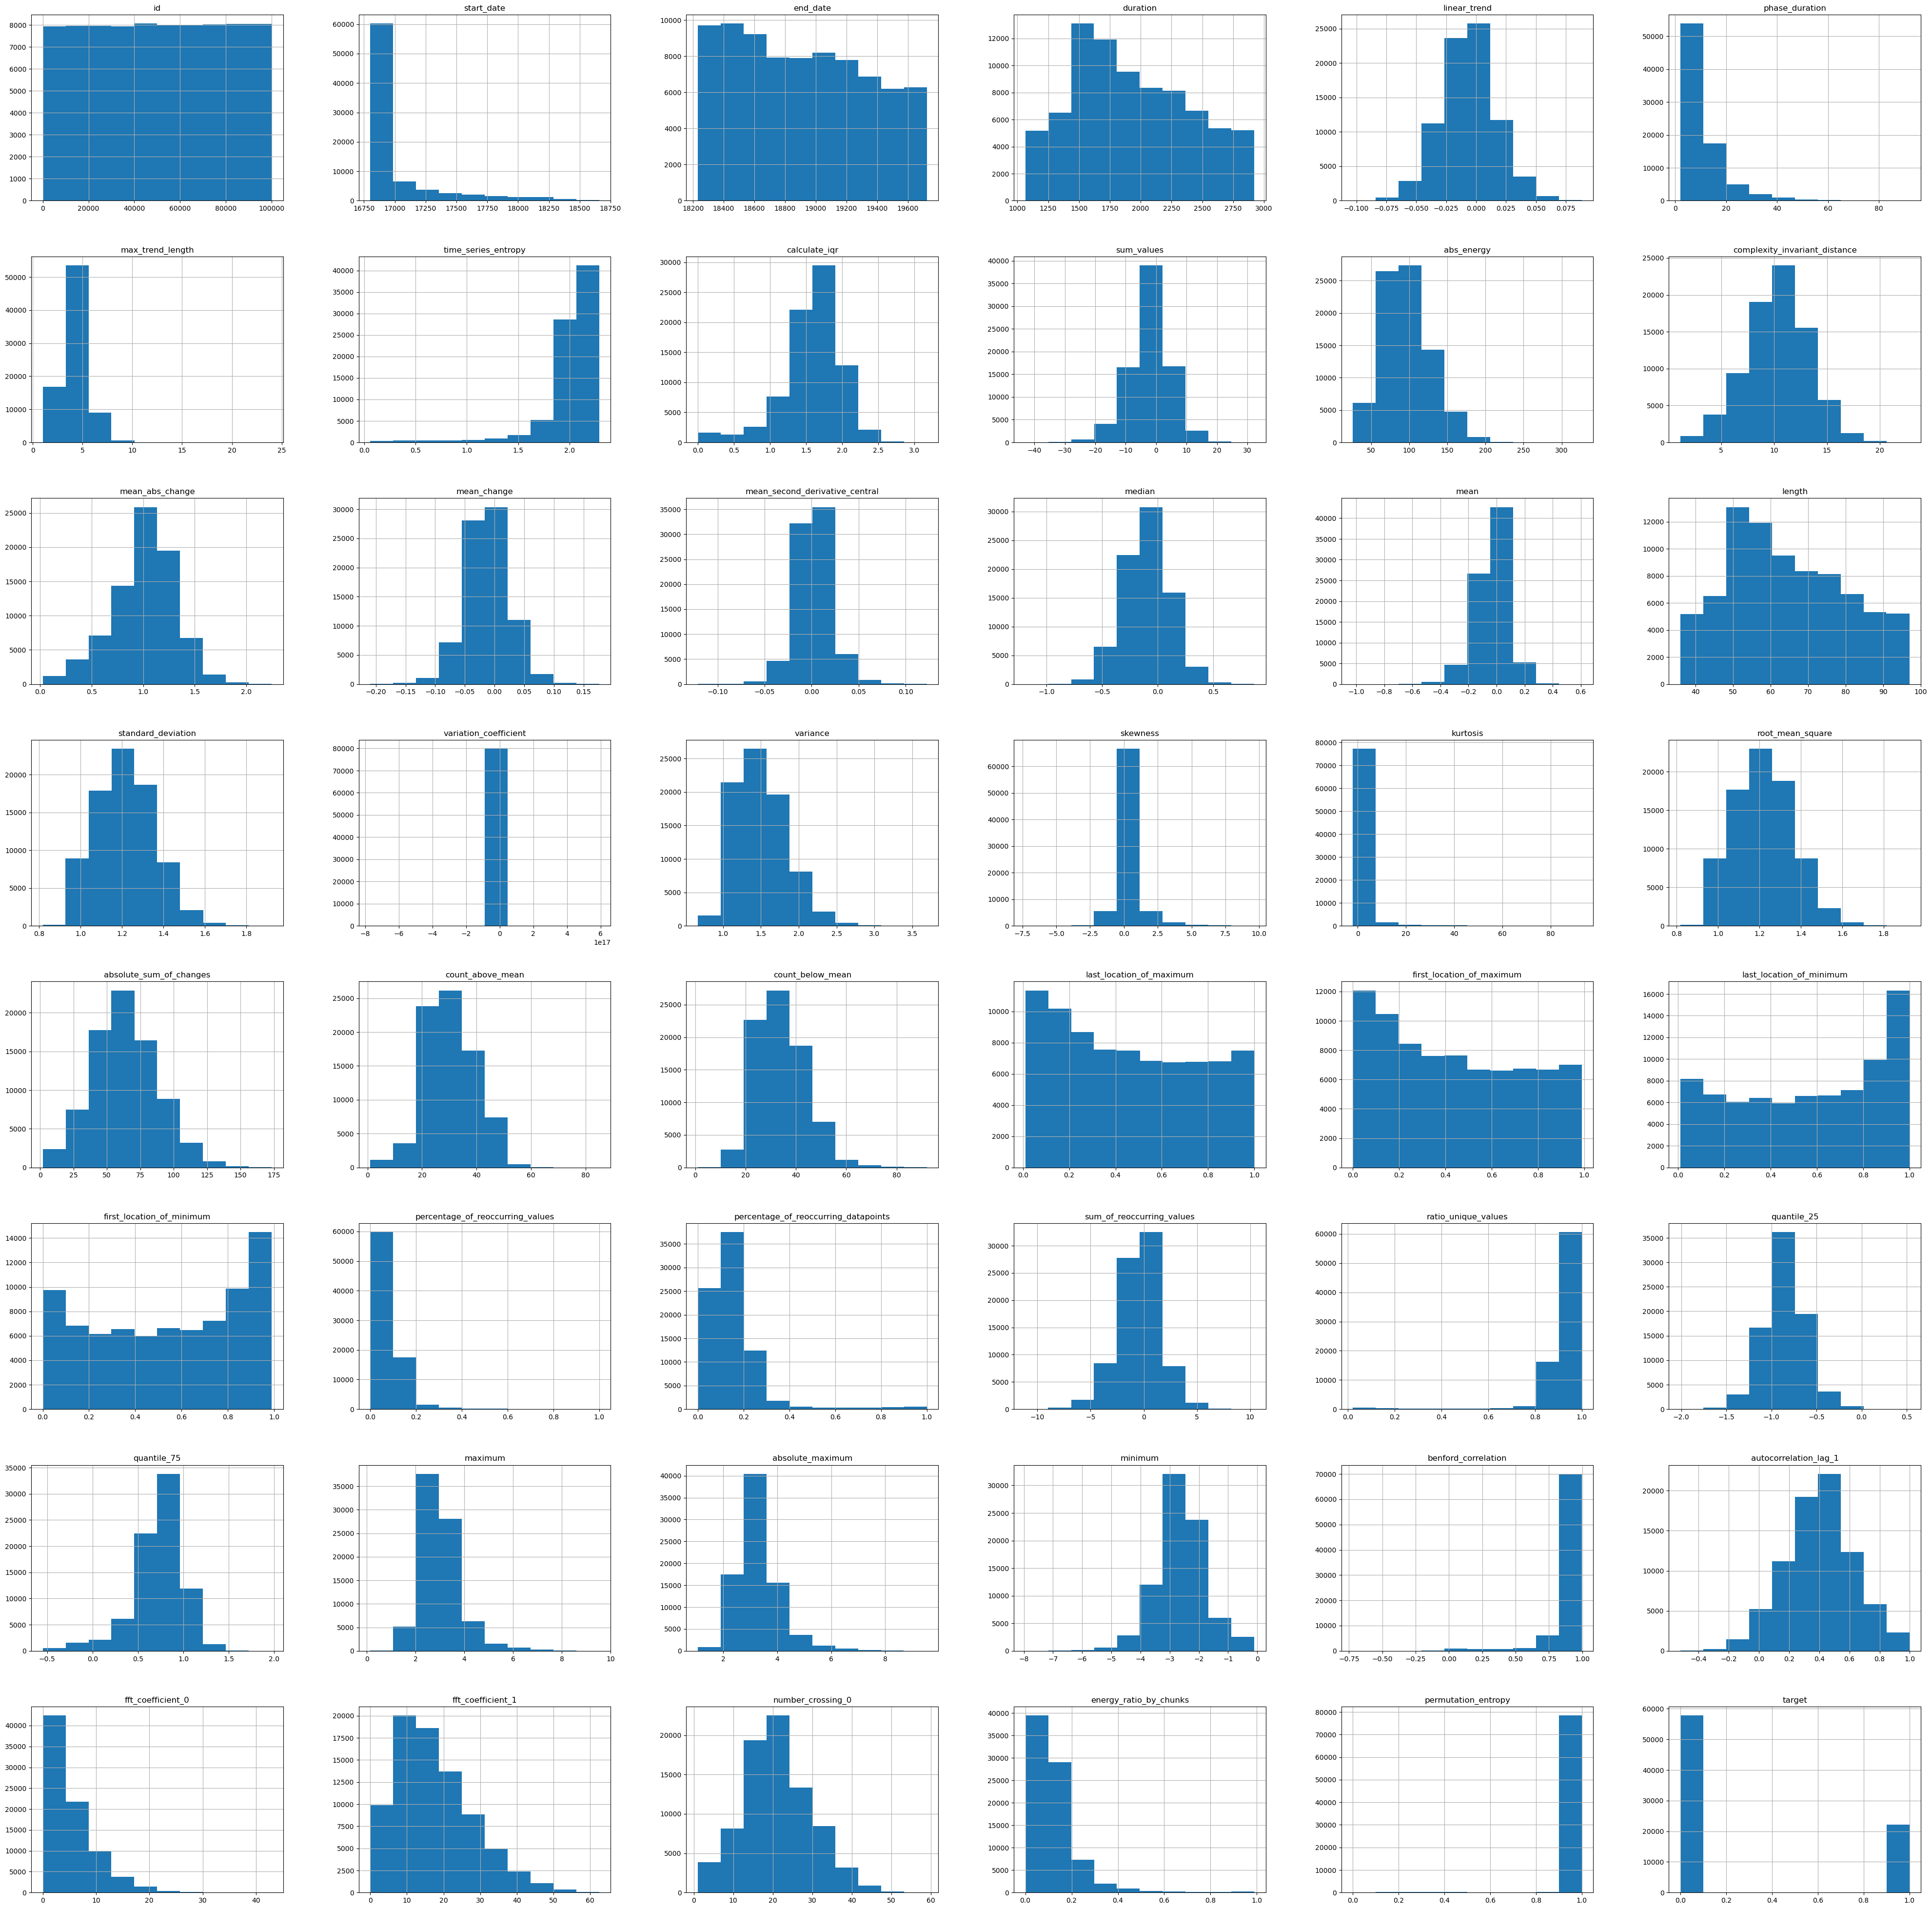

In [11]:
train_df.hist(figsize=(50, 50), layout=(-1, 6))
train_df.sample(3)

<Axes: >

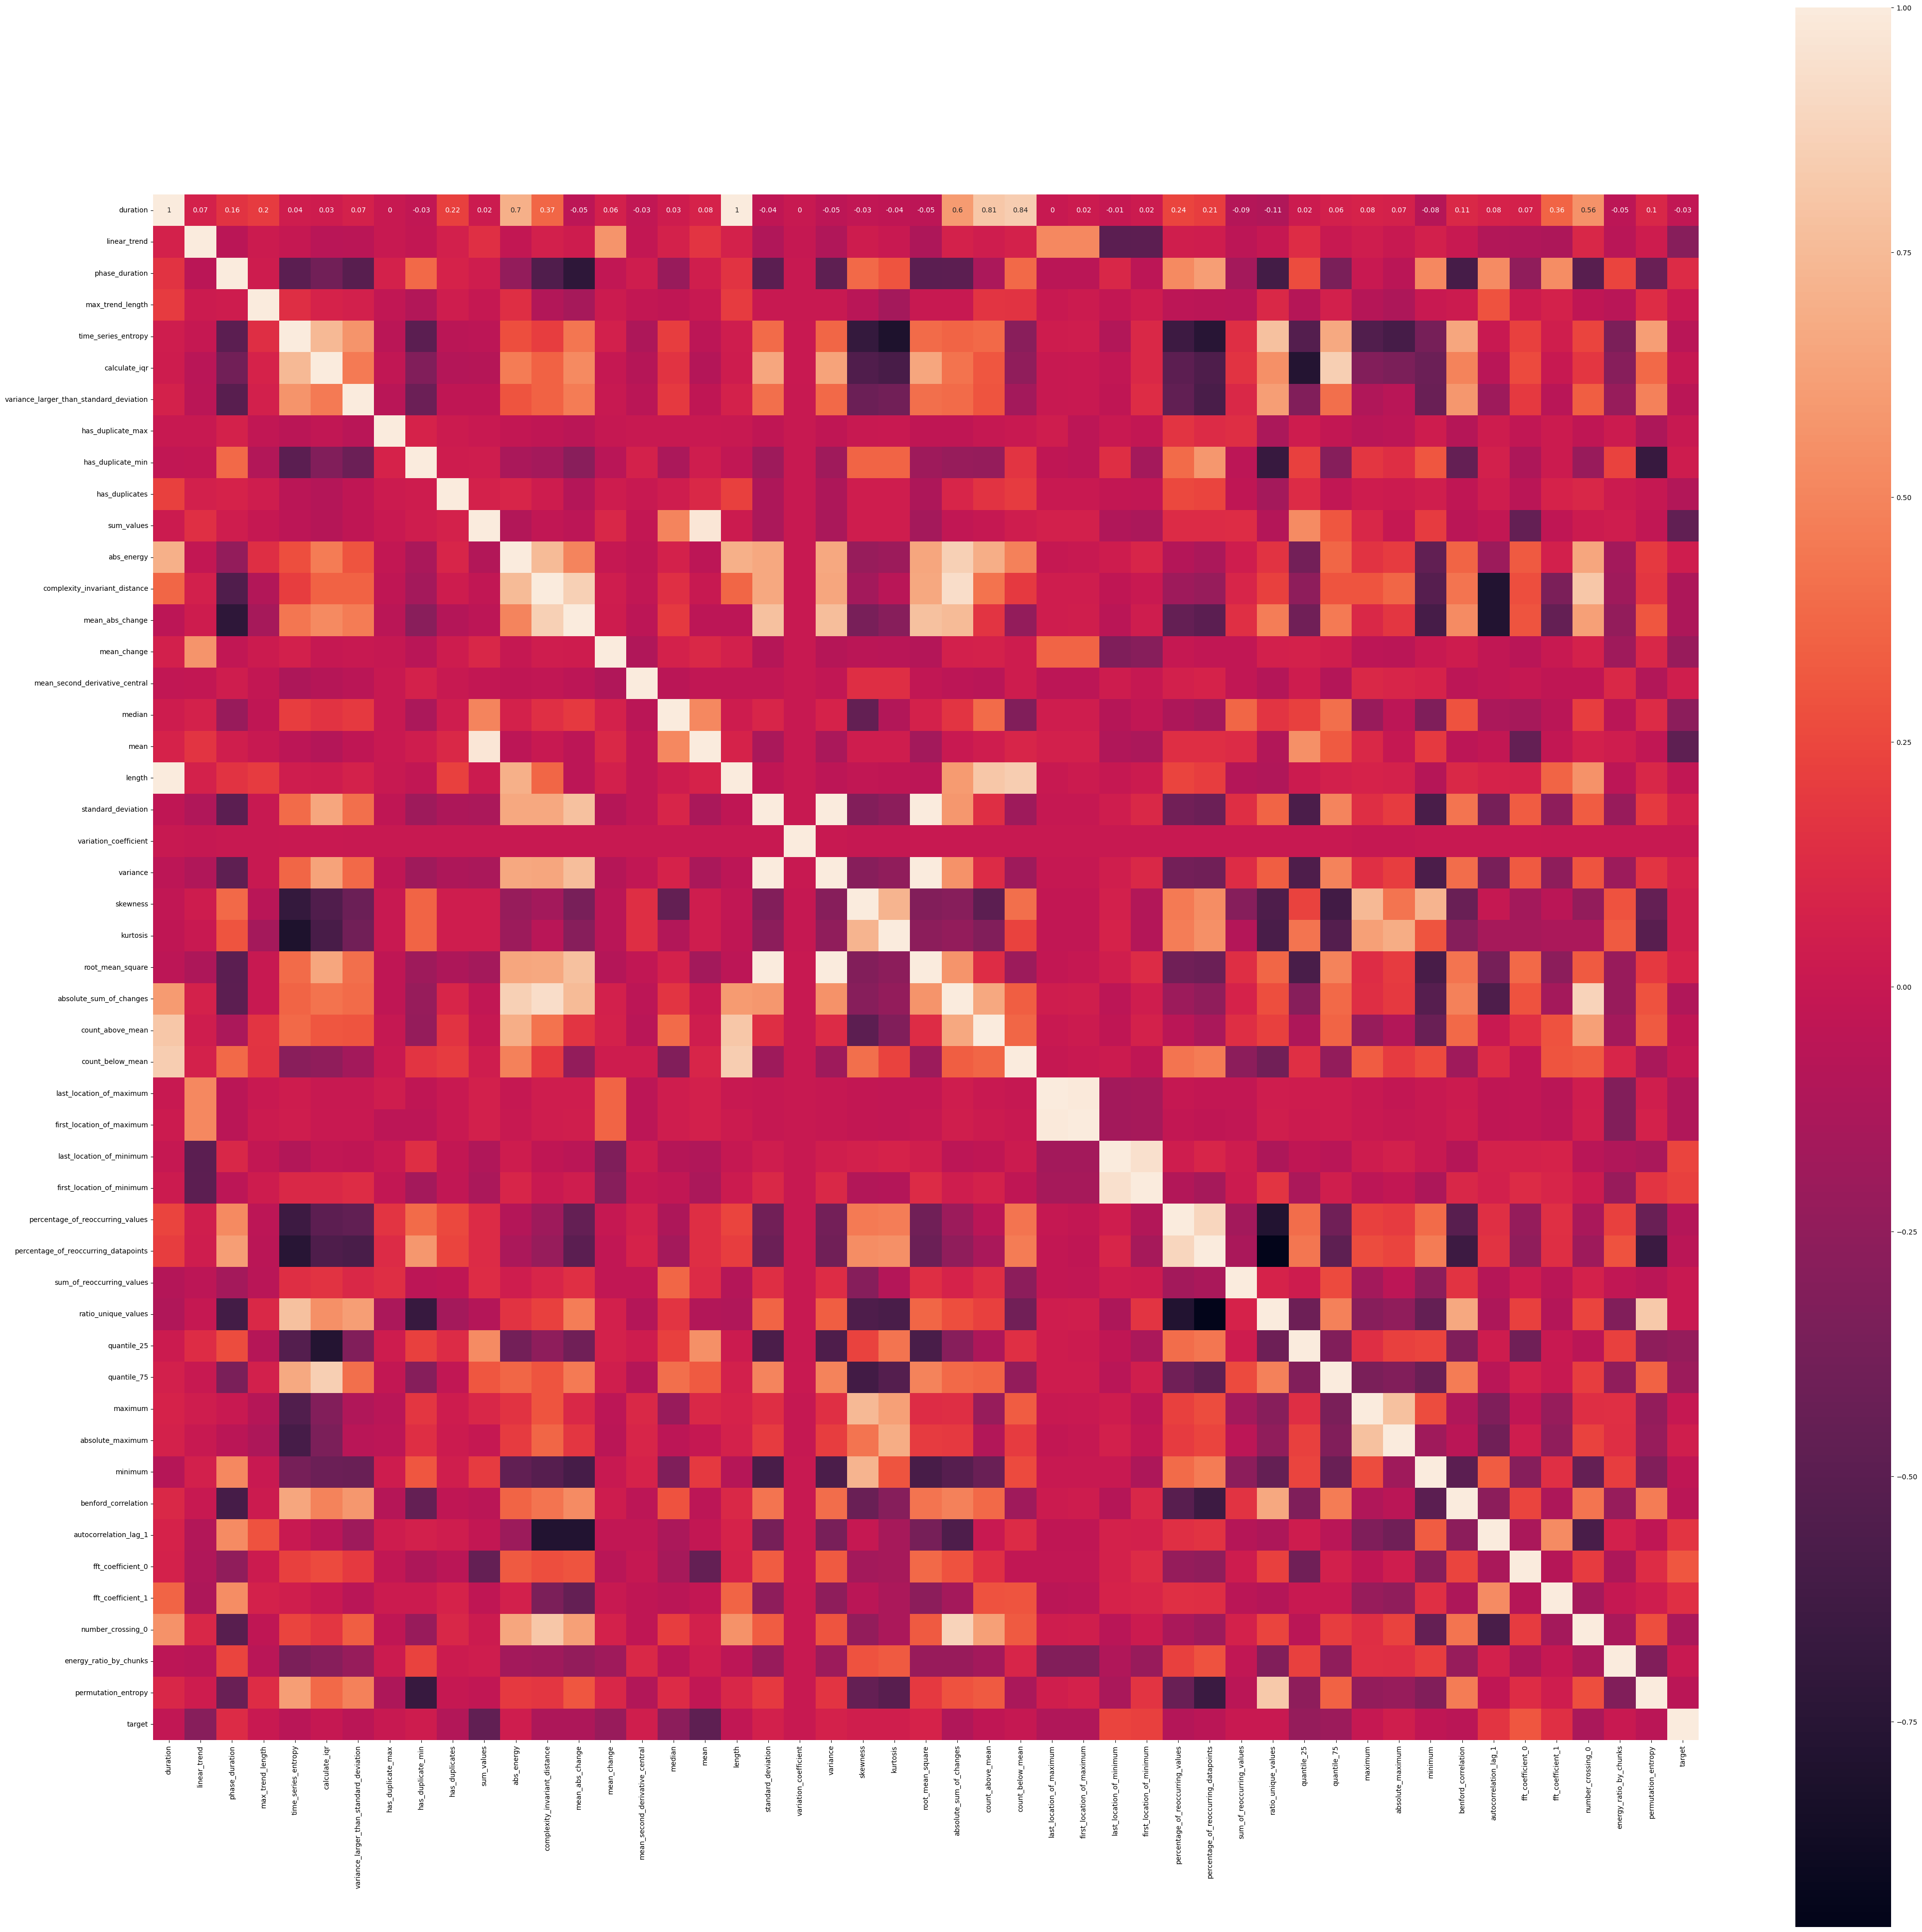

In [12]:
correlation_matrix = train_df.drop(["id", "start_date", "end_date"], axis=1).corr().round(2)

fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(data=correlation_matrix, square=True, annot=True, ax=ax)

In [13]:
train_df.describe().T.style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
id,79912.000000,50110.770635,28858.397752,0.000000,25122.500000,50148.500000,75068.500000,99999.000000
start_date,79912.000000,16979.790632,343.696518,16801.000000,16801.000000,16801.000000,16983.000000,18659.000000
end_date,79912.000000,18910.981067,434.264161,18231.000000,18536.000000,18871.000000,19266.000000,19723.000000
duration,79912.000000,1931.190434,468.483009,1064.000000,1552.000000,1858.000000,2282.000000,2922.000000
linear_trend,79912.000000,-0.000000,0.022797,-0.102966,-0.021057,-0.006180,0.007919,0.088318
phase_duration,79912.000000,nan,0.000000,2.000000,7.000000,9.000000,12.000000,92.000000
max_trend_length,79912.000000,nan,0.000000,1.000000,4.000000,4.000000,5.000000,24.000000
time_series_entropy,79912.000000,nan,0.000000,0.059418,1.966797,2.070312,2.138672,2.289062
calculate_iqr,79912.000000,nan,0.000000,0.000000,1.394531,1.629883,1.839844,3.169922
sum_values,79912.000000,nan,0.000000,-42.968750,-5.735352,-1.339844,2.080078,32.281250


Обучим catboost, брать линейные модели или KNN смысла не вижу, покажут результаты хуже.

In [16]:
X = train_df.drop(["id", "target"], axis=1, errors="ignore")
y = train_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

clf = CatBoostClassifier(
    iterations=2000,
    eval_metric='AUC',
    task_type="CPU",
    thread_count=-1,
    random_seed=7575,
    auto_class_weights="Balanced",
    early_stopping_rounds=50
)

clf.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100
)

Learning rate set to 0.065459
0:	test: 0.8520762	best: 0.8520762 (0)	total: 33.5ms	remaining: 1m 6s
100:	test: 0.9078441	best: 0.9078441 (100)	total: 3.21s	remaining: 1m
200:	test: 0.9144720	best: 0.9144720 (200)	total: 6.28s	remaining: 56.2s
300:	test: 0.9177520	best: 0.9177631 (299)	total: 9.26s	remaining: 52.3s
400:	test: 0.9193317	best: 0.9193317 (400)	total: 12.1s	remaining: 48.2s
500:	test: 0.9200852	best: 0.9201105 (495)	total: 15.2s	remaining: 45.5s
600:	test: 0.9205221	best: 0.9205378 (598)	total: 18.2s	remaining: 42.5s
700:	test: 0.9206637	best: 0.9206778 (698)	total: 21.1s	remaining: 39.1s
800:	test: 0.9207365	best: 0.9208739 (756)	total: 24.2s	remaining: 36.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9208739377
bestIteration = 756

Shrink model to first 757 iterations.


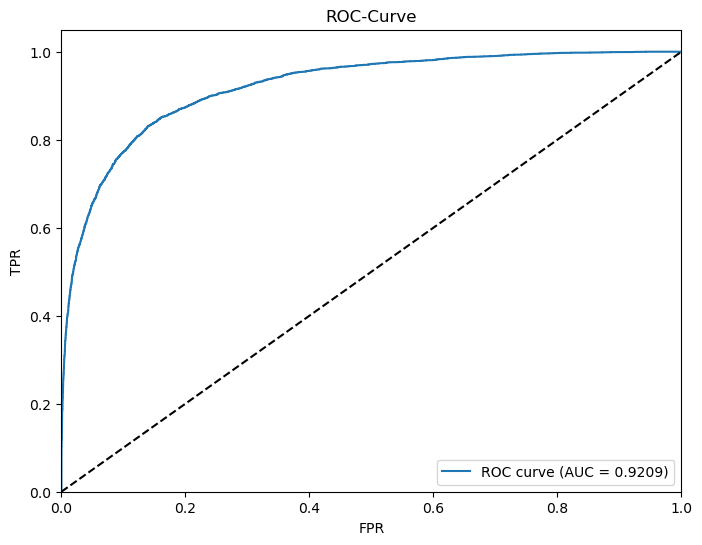

              precision    recall  f1-score   support

         0.0       0.93      0.86      0.90     11581
         1.0       0.70      0.82      0.76      4402

    accuracy                           0.85     15983
   macro avg       0.81      0.84      0.83     15983
weighted avg       0.86      0.85      0.86     15983



In [35]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve')
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_test, y_pred))

In [36]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,sum_values,11.535478
1,linear_trend,9.963147
2,mean,8.418297
3,last_location_of_minimum,5.059941
4,variation_coefficient,4.450091
5,autocorrelation_lag_1,3.750355
6,fft_coefficient_1,3.543680
7,abs_energy,3.029011
8,mean_abs_change,2.940893
9,last_location_of_maximum,2.898847


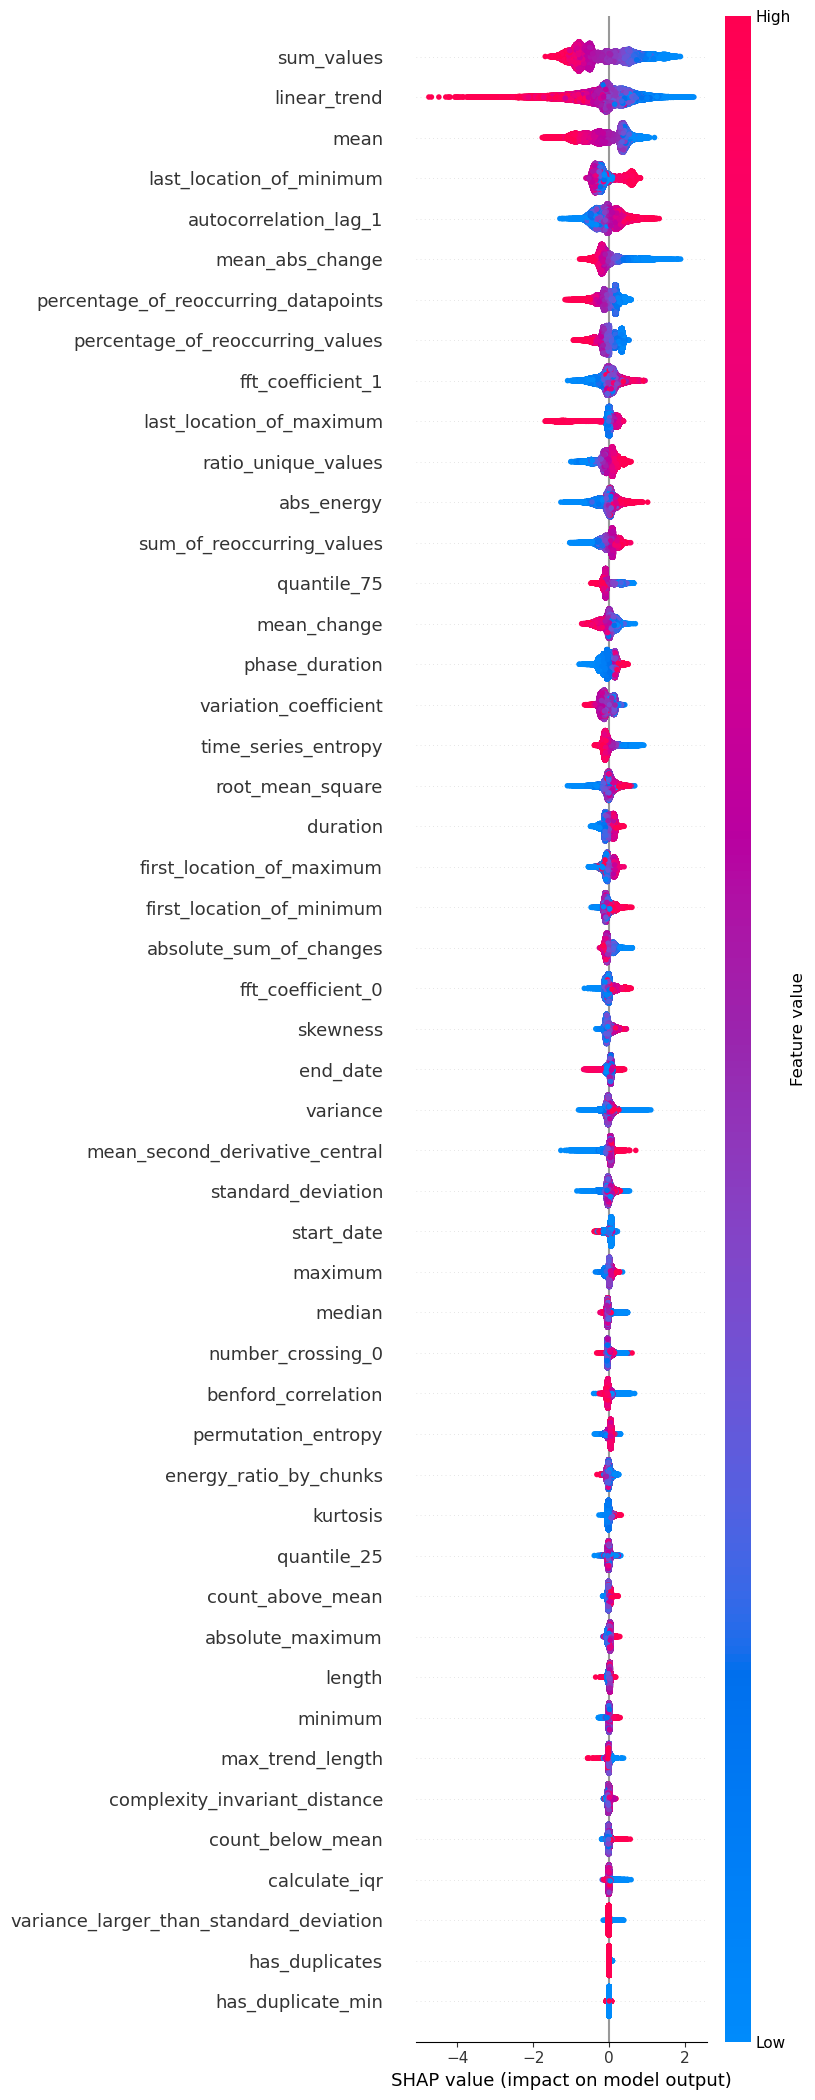

In [37]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)

shap.summary_plot(shap_values, X_train, max_display=49)

Возьмем признаки, которые дают 95% совокупной важности.

In [43]:
shap_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP Importance', ascending=False)

shap_importances['Cumulative Importance'] = shap_importances['SHAP Importance'].cumsum() / shap_importances['SHAP Importance'].sum()

selected_features = shap_importances[shap_importances['Cumulative Importance'] <= 0.97]['Feature'].values

selected_features

array(['sum_values', 'linear_trend', 'mean', 'last_location_of_minimum',
       'autocorrelation_lag_1', 'mean_abs_change',
       'percentage_of_reoccurring_datapoints',
       'percentage_of_reoccurring_values', 'fft_coefficient_1',
       'last_location_of_maximum', 'ratio_unique_values', 'abs_energy',
       'sum_of_reoccurring_values', 'quantile_75', 'mean_change',
       'phase_duration', 'variation_coefficient', 'time_series_entropy',
       'root_mean_square', 'duration', 'first_location_of_maximum',
       'first_location_of_minimum', 'absolute_sum_of_changes',
       'fft_coefficient_0', 'skewness', 'end_date', 'variance',
       'mean_second_derivative_central', 'standard_deviation',
       'start_date', 'maximum', 'median', 'number_crossing_0',
       'benford_correlation', 'permutation_entropy',
       'energy_ratio_by_chunks', 'kurtosis', 'quantile_25',
       'count_above_mean'], dtype=object)

In [47]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

clf.fit(X_train_selected, y_train, eval_set=(X_test_selected, y_test), verbose=100, early_stopping_rounds=100, plot=False)

Learning rate set to 0.065459
0:	test: 0.8511771	best: 0.8511771 (0)	total: 120ms	remaining: 3m 59s
100:	test: 0.9080393	best: 0.9080393 (100)	total: 3.18s	remaining: 59.7s
200:	test: 0.9150684	best: 0.9150684 (200)	total: 5.98s	remaining: 53.5s
300:	test: 0.9179829	best: 0.9179829 (300)	total: 8.89s	remaining: 50.2s
400:	test: 0.9192764	best: 0.9192888 (397)	total: 11.8s	remaining: 46.9s
500:	test: 0.9198509	best: 0.9198675 (496)	total: 14.5s	remaining: 43.3s
600:	test: 0.9203159	best: 0.9203653 (582)	total: 17.3s	remaining: 40.3s
700:	test: 0.9204746	best: 0.9204964 (674)	total: 20.1s	remaining: 37.2s
800:	test: 0.9206950	best: 0.9207008 (798)	total: 23.5s	remaining: 35.1s
900:	test: 0.9206808	best: 0.9208000 (844)	total: 26.5s	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9208000257
bestIteration = 844

Shrink model to first 845 iterations.


Бустинг из коробки показывает уже хороший результат, попробуем улучшить. Подберем гиперпараметры через optuna.

In [61]:
def objective(trial):
    param = {
        'iterations': 1200,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 20),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.8),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['SqrtBalanced', 'Balanced']),
        'depth': trial.suggest_int('depth', 4, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        'used_ram_limit': '10gb',
        'eval_metric': 'AUC',
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 20)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    clf = CatBoostClassifier(**param)
    clf.fit(X_train_selected, y_train, eval_set=(X_test_selected, y_test), verbose=0, early_stopping_rounds=100)

    preds = clf.predict_proba(X_test_selected)[:, 1]
    roc_auc = roc_auc_score(y_test, preds)
    return roc_auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-29 18:55:15,577] A new study created in memory with name: no-name-24032240-58be-4cb9-9c92-e7d9823a7959


[I 2024-10-29 18:57:08,542] Trial 0 finished with value: 0.9149656483906236 and parameters: {'learning_rate': 0.09216335686323912, 'l2_leaf_reg': 12, 'colsample_bylevel': 0.2834020014404589, 'auto_class_weights': 'Balanced', 'depth': 9, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'random_strength': 3.2190116211202864}. Best is trial 0 with value: 0.9149656483906236.
[I 2024-10-29 18:57:29,987] Trial 1 finished with value: 0.9194663736028175 and parameters: {'learning_rate': 0.03626396770172258, 'l2_leaf_reg': 4, 'colsample_bylevel': 0.3770194192792934, 'auto_class_weights': 'SqrtBalanced', 'depth': 5, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain', 'random_strength': 6.86247952579816}. Best is trial 1 with value: 0.9194663736028175.
[I 2024-10-29 19:07:04,692] Trial 2 finished with value: 0.9198636308409242 and parameters: {'learning_rate': 0.05875078071323218, 'l2_leaf_reg': 20, 'colsample_bylevel': 0.2618836982523212, 'auto_class_weights': 'Balanced', 'depth': 10, 'bootst

Сохраним лучшие гиперпараметры.


In [62]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9212998534589214, params {'learning_rate': 0.05549981700358849, 'l2_leaf_reg': 17, 'colsample_bylevel': 0.7096296254119971, 'auto_class_weights': 'Balanced', 'depth': 7, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain', 'random_strength': 2.7716379366222275}
